In [1]:
import sys
sys.path.insert(0, '../models/')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from Bio import SeqIO
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input,Conv1D, Dense,LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation,AveragePooling1D
from tensorflow.keras import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 ,l1
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import model_from_yaml
import keras
from tensorflow.keras.initializers import RandomUniform
import keras.backend as K
from random import shuffle
from sklearn.utils import class_weight
from tcn import TCN

import h5py
import scipy.io
import gzip
import re
import random
np.random.seed(1337)

2023-07-14 20:07:46.377396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
enh_pos_seq = []
for seq_record in SeqIO.parse('datasets/Fulltranscriptmode-train-Pos.txt', "fasta"):
    enh_pos_seq.append(str(seq_record.seq))
enh_neg_seq = []
for seq_record in SeqIO.parse('datasets/Fulltranscriptmode-train-Neg.txt', "fasta"):
    enh_neg_seq.append(str(seq_record.seq))
enh_combine_seqs = enh_pos_seq + enh_neg_seq
    

In [3]:
import re
def get_feature(all_seqs,patterns):
    all_feat = []
    for seq in all_seqs:
        feat= np.zeros((1,len(patterns)))
        ix=0
        for ix, pattern in enumerate(patterns):
            pat='(?='+pattern+')'
            featcnt=len(re.findall(pat,seq))
            feat[0,ix] = featcnt
            ix+=1
        all_feat.append(feat)
    return np.asarray(all_feat)

#patterns= ['AA','AC','AU','AG','CA','CC','CU','CG','UA','UC','UU','UG','GA','GC','GU','GG']
#patterns= ['AAA','AAC','AAU','AAG','ACA','ACC','ACU', 'ACG','AUA','AUC','AUU','AUG','AGA','AGC','AGU', 'AGG','CAA','CAC','CAU','CAG','UAA','UAC','UAU', 'UAG','GAA','GAC','GAU','GAG','CCA','CCC','CCU', 'CCG','UUA','UUC','UUU','UUG','GGA','GGC','GGU', 'GGG','UCA','UCC','UCU','UCG','GCA','GCC','GCU','GCG','CUA','CUC','CUU','CUG','GUA','GUC','GUU','AGG','CGA','CGC','CGU','GGG','UUU','AUA','CUA', 'GUA']
patterns=['AAAA','AAAC','AAAG','AAAU','AACA','AACC','AACG','AACU','AAGA','AAGC','AAGG','AAGU','AAUA','AAUC','AAUG','AAUU','ACAA','ACAC','ACAG','ACAU','ACCA','ACCC','ACCG','ACCU','ACGA','ACGC','ACGG','ACGU','ACUA','ACUC','ACUG','ACUU','AGAA','AGAC','AGAG','AGAU','AGCA','AGCC','AGCG','AGCU','AGGA','AGGC','AGGG','AGGU','AGUA','AGUC','AGUG','AGUU','AUAA','AUAC','AUAG','AUAU','AUCA','AUCC','AUCG','AUCU','AUGA','AUGC','AUGG','AUGU','AUUA','AUUC','AUUG','AUUU','CAAA','CAAC','CAAG','CAAU','CACA','CACC','CACG','CACU','CAGA','CAGC','CAGG','CAGU','CAUA','CAUC','CAUG','CAUU','CCAA','CCAC','CCAG','CCAU','CCCA','CCCC','CCCG','CCCU','CCGA','CCGC','CCGG','CCGU','CCUA','CCUC','CCUG','CCUU','CGAA','CGAC','CGAG','CGAU','CGCA','CGCC','CGCG','CGCU','CGGA','CGGC','CGGG','CGGU','CGUA','CGUC','CGUG','CGUU','CUAA','CUAC','CUAG','CUAU','CUCA','CUCC','CUCG','CUCU','CUGA','CUGC','CUGG','CUGU','CUUA','CUUC','CUUG','CUUU','GAAA','GAAC','GAAG','GAAU','GACA','GACC','GACG','GACU','GAGA','GAGC','GAGG','GAGU','GAUA','GAUC','GAUG','GAUU','GCAA','GCAC','GCAG','GCAU','GCCA','GCCC','GCCG','GCCU','GCGA','GCGC','GCGG','GCGU','GCUA','GCUC','GCUG','GCUU','GGAA','GGAC','GGAG','GGAU','GGCA','GGCC','GGCG','GGCU','GGGA','GGGC','GGGG','GGGU','GGUA','GGUC','GGUG','GGUU','GUAA','GUAC','GUAG','GUAU','GUCA','GUCC','GUCG','GUCU','GUGA','GUGC','GUGG','GUGU','GUUA','GUUC','GUUG','GUUU','UAAA','UAAC','UAAG','UAAU','UACA','UACC','UACG','UACU','UAGA','UAGC','UAGG','UAGU','UAUA','UAUC','UAUG','UAUU','UCAA','UCAC','UCAG','UCAU','UCCA','UCCC','UCCG','UCCU','UCGA','UCGC','UCGG','UCGU','UCUA','UCUC','UCUG','UCUU','UGAA','UGAC','UGAG','UGAU','UGCA','UGCC','UGCG','UGCU','UGGA','UGGC','UGGG','UGGU','UGUA','UGUC','UGUG','UGUU','UUAA','UUAC','UUAG','UUAU','UUCA','UUCC','UUCG','UUCU','UUGA','UUGC','UUGG','UUGU','UUUA','UUUC','UUUG','UUUU']
#patterns=['AAAAA','AAAAC','AAAAG','AAAAU','AAACA','AAACC','AAACG','AAACU','AAAGA','AAAGC','AAAGG','AAAGU','AAAUA','AAAUC','AAAUG','AAAUU','AACAA','AACAC','AACAG','AACAU','AACCA','AACCC','AACCG','AACCU','AACGA','AACGC','AACGG','AACGU','AACUA','AACUC','AACUG','AACUU','AAGAA','AAGAC','AAGAG','AAGAU','AAGCA','AAGCC','AAGCG','AAGCU','AAGGA','AAGGC','AAGGG','AAGGU','AAGUA','AAGUC','AAGUG','AAGUU','AAUAA','AAUAC','AAUAG','AAUAU','AAUCA','AAUCC','AAUCG','AAUCU','AAUGA','AAUGC','AAUGG','AAUGU','AAUUA','AAUUC','AAUUG','AAUUU','ACAAA','ACAAC','ACAAG','ACAAU','ACACA','ACACC','ACACG','ACACU','ACAGA','ACAGC','ACAGG','ACAGU','ACAUA','ACAUC','ACAUG','ACAUU','ACCAA','ACCAC','ACCAG','ACCAU','ACCCA','ACCCC','ACCCG','ACCCU','ACCGA','ACCGC','ACCGG','ACCGU','ACCUA','ACCUC','ACCUG','ACCUU','ACGAA','ACGAC','ACGAG','ACGAU','ACGCA','ACGCC','ACGCG','ACGCU','ACGGA','ACGGC','ACGGG','ACGGU','ACGUA','ACGUC','ACGUG','ACGUU','ACUAA','ACUAC','ACUAG','ACUAU','ACUCA','ACUCC','ACUCG','ACUCU','ACUGA','ACUGC','ACUGG','ACUGU','ACUUA','ACUUC','ACUUG','ACUUU','AGAAA','AGAAC','AGAAG','AGAAU','AGACA','AGACC','AGACG','AGACU','AGAGA','AGAGC','AGAGG','AGAGU','AGAUA','AGAUC','AGAUG','AGAUU','AGCAA','AGCAC','AGCAG','AGCAU','AGCCA','AGCCC','AGCCG','AGCCU','AGCGA','AGCGC','AGCGG','AGCGU','AGCUA','AGCUC','AGCUG','AGCUU','AGGAA','AGGAC','AGGAG','AGGAU','AGGCA','AGGCC','AGGCG','AGGCU','AGGGA','AGGGC','AGGGG','AGGGU','AGGUA','AGGUC','AGGUG','AGGUU','AGUAA','AGUAC','AGUAG','AGUAU','AGUCA','AGUCC','AGUCG','AGUCU','AGUGA','AGUGC','AGUGG','AGUGU','AGUUA','AGUUC','AGUUG','AGUUU','AUAAA','AUAAC','AUAAG','AUAAU','AUACA','AUACC','AUACG','AUACU','AUAGA','AUAGC','AUAGG','AUAGU','AUAUA','AUAUC','AUAUG','AUAUU','AUCAA','AUCAC','AUCAG','AUCAU','AUCCA','AUCCC','AUCCG','AUCCU','AUCGA','AUCGC','AUCGG','AUCGU','AUCUA','AUCUC','AUCUG','AUCUU','AUGAA','AUGAC','AUGAG','AUGAU','AUGCA','AUGCC','AUGCG','AUGCU','AUGGA','AUGGC','AUGGG','AUGGU','AUGUA','AUGUC','AUGUG','AUGUU','AUUAA','AUUAC','AUUAG','AUUAU','AUUCA','AUUCC','AUUCG','AUUCU','AUUGA','AUUGC','AUUGG','AUUGU','AUUUA','AUUUC','AUUUG','AUUUU','CAAAA','CAAAC','CAAAG','CAAAU','CAACA','CAACC','CAACG','CAACU','CAAGA','CAAGC','CAAGG','CAAGU','CAAUA','CAAUC','CAAUG','CAAUU','CACAA','CACAC','CACAG','CACAU','CACCA','CACCC','CACCG','CACCU','CACGA','CACGC','CACGG','CACGU','CACUA','CACUC','CACUG','CACUU','CAGAA','CAGAC','CAGAG','CAGAU','CAGCA','CAGCC','CAGCG','CAGCU','CAGGA','CAGGC','CAGGG','CAGGU','CAGUA','CAGUC','CAGUG','CAGUU','CAUAA','CAUAC','CAUAG','CAUAU','CAUCA','CAUCC','CAUCG','CAUCU','CAUGA','CAUGC','CAUGG','CAUGU','CAUUA','CAUUC','CAUUG','CAUUU','CCAAA','CCAAC','CCAAG','CCAAU','CCACA','CCACC','CCACG','CCACU','CCAGA','CCAGC','CCAGG','CCAGU','CCAUA','CCAUC','CCAUG','CCAUU','CCCAA','CCCAC','CCCAG','CCCAU','CCCCA','CCCCC','CCCCG','CCCCU','CCCGA','CCCGC','CCCGG','CCCGU','CCCUA','CCCUC','CCCUG','CCCUU','CCGAA','CCGAC','CCGAG','CCGAU','CCGCA','CCGCC','CCGCG','CCGCU','CCGGA','CCGGC','CCGGG','CCGGU','CCGUA','CCGUC','CCGUG','CCGUU','CCUAA','CCUAC','CCUAG','CCUAU','CCUCA','CCUCC','CCUCG','CCUCU','CCUGA','CCUGC','CCUGG','CCUGU','CCUUA','CCUUC','CCUUG','CCUUU','CGAAA','CGAAC','CGAAG','CGAAU','CGACA','CGACC','CGACG','CGACU','CGAGA','CGAGC','CGAGG','CGAGU','CGAUA','CGAUC','CGAUG','CGAUU','CGCAA','CGCAC','CGCAG','CGCAU','CGCCA','CGCCC','CGCCG','CGCCU','CGCGA','CGCGC','CGCGG','CGCGU','CGCUA','CGCUC','CGCUG','CGCUU','CGGAA','CGGAC','CGGAG','CGGAU','CGGCA','CGGCC','CGGCG','CGGCU','CGGGA','CGGGC','CGGGG','CGGGU','CGGUA','CGGUC','CGGUG','CGGUU','CGUAA','CGUAC','CGUAG','CGUAU','CGUCA','CGUCC','CGUCG','CGUCU','CGUGA','CGUGC','CGUGG','CGUGU','CGUUA','CGUUC','CGUUG','CGUUU','CUAAA','CUAAC','CUAAG','CUAAU','CUACA','CUACC','CUACG','CUACU','CUAGA','CUAGC','CUAGG','CUAGU','CUAUA','CUAUC','CUAUG','CUAUU','CUCAA','CUCAC','CUCAG','CUCAU','CUCCA','CUCCC','CUCCG','CUCCU','CUCGA','CUCGC','CUCGG','CUCGU','CUCUA','CUCUC','CUCUG','CUCUU','CUGAA','CUGAC','CUGAG','CUGAU','CUGCA','CUGCC','CUGCG','CUGCU','CUGGA','CUGGC','CUGGG','CUGGU','CUGUA','CUGUC','CUGUG','CUGUU','CUUAA','CUUAC','CUUAG','CUUAU','CUUCA','CUUCC','CUUCG','CUUCU','CUUGA','CUUGC','CUUGG','CUUGU','CUUUA','CUUUC','CUUUG','CUUUU','GAAAA','GAAAC','GAAAG','GAAAU','GAACA','GAACC','GAACG','GAACU','GAAGA','GAAGC','GAAGG','GAAGU','GAAUA','GAAUC','GAAUG','GAAUU','GACAA','GACAC','GACAG','GACAU','GACCA','GACCC','GACCG','GACCU','GACGA','GACGC','GACGG','GACGU','GACUA','GACUC','GACUG','GACUU','GAGAA','GAGAC','GAGAG','GAGAU','GAGCA','GAGCC','GAGCG','GAGCU','GAGGA','GAGGC','GAGGG','GAGGU','GAGUA','GAGUC','GAGUG','GAGUU','GAUAA','GAUAC','GAUAG','GAUAU','GAUCA','GAUCC','GAUCG','GAUCU','GAUGA','GAUGC','GAUGG','GAUGU','GAUUA','GAUUC','GAUUG','GAUUU','GCAAA','GCAAC','GCAAG','GCAAU','GCACA','GCACC','GCACG','GCACU','GCAGA','GCAGC','GCAGG','GCAGU','GCAUA','GCAUC','GCAUG','GCAUU','GCCAA','GCCAC','GCCAG','GCCAU','GCCCA','GCCCC','GCCCG','GCCCU','GCCGA','GCCGC','GCCGG','GCCGU','GCCUA','GCCUC','GCCUG','GCCUU','GCGAA','GCGAC','GCGAG','GCGAU','GCGCA','GCGCC','GCGCG','GCGCU','GCGGA','GCGGC','GCGGG','GCGGU','GCGUA','GCGUC','GCGUG','GCGUU','GCUAA','GCUAC','GCUAG','GCUAU','GCUCA','GCUCC','GCUCG','GCUCU','GCUGA','GCUGC','GCUGG','GCUGU','GCUUA','GCUUC','GCUUG','GCUUU','GGAAA','GGAAC','GGAAG','GGAAU','GGACA','GGACC','GGACG','GGACU','GGAGA','GGAGC','GGAGG','GGAGU','GGAUA','GGAUC','GGAUG','GGAUU','GGCAA','GGCAC','GGCAG','GGCAU','GGCCA','GGCCC','GGCCG','GGCCU','GGCGA','GGCGC','GGCGG','GGCGU','GGCUA','GGCUC','GGCUG','GGCUU','GGGAA','GGGAC','GGGAG','GGGAU','GGGCA','GGGCC','GGGCG','GGGCU','GGGGA','GGGGC','GGGGG','GGGGU','GGGUA','GGGUC','GGGUG','GGGUU','GGUAA','GGUAC','GGUAG','GGUAU','GGUCA','GGUCC','GGUCG','GGUCU','GGUGA','GGUGC','GGUGG','GGUGU','GGUUA','GGUUC','GGUUG','GGUUU','GUAAA','GUAAC','GUAAG','GUAAU','GUACA','GUACC','GUACG','GUACU','GUAGA','GUAGC','GUAGG','GUAGU','GUAUA','GUAUC','GUAUG','GUAUU','GUCAA','GUCAC','GUCAG','GUCAU','GUCCA','GUCCC','GUCCG','GUCCU','GUCGA','GUCGC','GUCGG','GUCGU','GUCUA','GUCUC','GUCUG','GUCUU','GUGAA','GUGAC','GUGAG','GUGAU','GUGCA','GUGCC','GUGCG','GUGCU','GUGGA','GUGGC','GUGGG','GUGGU','GUGUA','GUGUC','GUGUG','GUGUU','GUUAA','GUUAC','GUUAG','GUUAU','GUUCA','GUUCC','GUUCG','GUUCU','GUUGA','GUUGC','GUUGG','GUUGU','GUUUA','GUUUC','GUUUG','GUUUU','UAAAA','UAAAC','UAAAG','UAAAU','UAACA','UAACC','UAACG','UAACU','UAAGA','UAAGC','UAAGG','UAAGU','UAAUA','UAAUC','UAAUG','UAAUU','UACAA','UACAC','UACAG','UACAU','UACCA','UACCC','UACCG','UACCU','UACGA','UACGC','UACGG','UACGU','UACUA','UACUC','UACUG','UACUU','UAGAA','UAGAC','UAGAG','UAGAU','UAGCA','UAGCC','UAGCG','UAGCU','UAGGA','UAGGC','UAGGG','UAGGU','UAGUA','UAGUC','UAGUG','UAGUU','UAUAA','UAUAC','UAUAG','UAUAU','UAUCA','UAUCC','UAUCG','UAUCU','UAUGA','UAUGC','UAUGG','UAUGU','UAUUA','UAUUC','UAUUG','UAUUU','UCAAA','UCAAC','UCAAG','UCAAU','UCACA','UCACC','UCACG','UCACU','UCAGA','UCAGC','UCAGG','UCAGU','UCAUA','UCAUC','UCAUG','UCAUU','UCCAA','UCCAC','UCCAG','UCCAU','UCCCA','UCCCC','UCCCG','UCCCU','UCCGA','UCCGC','UCCGG','UCCGU','UCCUA','UCCUC','UCCUG','UCCUU','UCGAA','UCGAC','UCGAG','UCGAU','UCGCA','UCGCC','UCGCG','UCGCU','UCGGA','UCGGC','UCGGG','UCGGU','UCGUA','UCGUC','UCGUG','UCGUU','UCUAA','UCUAC','UCUAG','UCUAU','UCUCA','UCUCC','UCUCG','UCUCU','UCUGA','UCUGC','UCUGG','UCUGU','UCUUA','UCUUC','UCUUG','UCUUU','UGAAA','UGAAC','UGAAG','UGAAU','UGACA','UGACC','UGACG','UGACU','UGAGA','UGAGC','UGAGG','UGAGU','UGAUA','UGAUC','UGAUG','UGAUU','UGCAA','UGCAC','UGCAG','UGCAU','UGCCA','UGCCC','UGCCG','UGCCU','UGCGA','UGCGC','UGCGG','UGCGU','UGCUA','UGCUC','UGCUG','UGCUU','UGGAA','UGGAC','UGGAG','UGGAU','UGGCA','UGGCC','UGGCG','UGGCU','UGGGA','UGGGC','UGGGG','UGGGU','UGGUA','UGGUC','UGGUG','UGGUU','UGUAA','UGUAC','UGUAG','UGUAU','UGUCA','UGUCC','UGUCG','UGUCU','UGUGA','UGUGC','UGUGG','UGUGU','UGUUA','UGUUC','UGUUG','UGUUU','UUAAA','UUAAC','UUAAG','UUAAU','UUACA','UUACC','UUACG','UUACU','UUAGA','UUAGC','UUAGG','UUAGU','UUAUA','UUAUC','UUAUG','UUAUU','UUCAA','UUCAC','UUCAG','UUCAU','UUCCA','UUCCC','UUCCG','UUCCU','UUCGA','UUCGC','UUCGG','UUCGU','UUCUA','UUCUC','UUCUG','UUCUU','UUGAA','UUGAC','UUGAG','UUGAU','UUGCA','UUGCC','UUGCG','UUGCU','UUGGA','UUGGC','UUGGG','UUGGU','UUGUA','UUGUC','UUGUG','UUGUU','UUUAA','UUUAC','UUUAG','UUUAU','UUUCA','UUUCC','UUUCG','UUUCU','UUUGA','UUUGC','UUUGG','UUUGU','UUUUA','UUUUC','UUUUG','UUUUU']
#paUUerns= ['A','C','U','G','AA','AC','AU','AG','CA','CC', 'CU','CG','UA','UC','UU','UG','GA','GC','GU', 'GG','AAA','AAC','AAU','AAG','ACA','ACC','ACU', 'ACG','AUA','AUC','AUU','AUG','AGA','AGC','AGU', 'AGG','CAA','CAC','CAU','CAG','UAA','UAC','UAU', 'UAG','GAA','GAC','GAU','GAG','CCA','CCC','CCU', 'CCG','UUA','UUC','UUU','UUG','GGA','GGC','GGU', 'GGG','UCA','UCC','UCU','UCG','GCA','GCC','GCU','GCG','CUA','CUC','CUU','CUG','GUA','GUC','GUU','AGG','CGA','CGC','CGU','GGG','UUU','AUA','CUA', 'GUA']


In [4]:
enh_kmer_feature=get_feature(enh_combine_seqs,patterns)


In [5]:
enh_kmer_feature.shape


(4396, 1, 256)

In [6]:
bases = ['A','C','G','U']
def onehot(seq):
    X = np.zeros((len(seq),len(seq[0]), len(bases)))
    print(len(seq),len(seq[0]), len(bases))
    for l,s in enumerate(seq):
        for i, char in enumerate(s):
            if char in bases:
                X[l,i, bases.index(char)] = 1
    return X
def shuffle_ab(a,b,c):
    s = np.arange(a.shape[0])
    shuffle(s)
    return a[s],b[s],c[s]

In [7]:
from sklearn.utils import compute_class_weight
lbs = list(np.ones(len(enh_pos_seq))) + list(np.zeros(len(enh_neg_seq)))
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(lbs),
                                        y = lbs                                                    
                                    )
class_weights = dict(zip(np.unique(lbs), class_weights))
class_weights

{0.0: 0.7679944095038435, 1.0: 1.4328552803129075}

In [8]:
p=list(np.zeros(len(enh_pos_seq))) 
print(len(p))

1534


In [9]:
enh_features = onehot(enh_combine_seqs)
enh_features=np.asarray(enh_features,dtype=np.float)
enh_features.shape

4396 41 4


(4396, 41, 4)

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder() 
lbs = np.array(lbs).reshape(-1, 1)
Input_labels = one_hot_encoder.fit_transform(lbs).toarray()
Input_labels = np.array(lbs)
Input_labels.shape

(4396, 1)

In [11]:
enh_features,enh_kmer,Input_labels=shuffle_ab(enh_features,enh_kmer_feature,Input_labels)


In [12]:
class CustomModelCheckpoint(keras.callbacks.Callback):
    def __init__(self, model, path):
        self.path = path
        self.model_for_saving = model
    def on_epoch_end(self, epoch, logs=None):
        loss = logs['val_loss']
        print("\nSaving model to : {}".format(self.path.format(epoch=epoch, val_loss=loss)))
        self.model_for_saving.save_weights(self.path.format(epoch=epoch, val_loss=loss), overwrite=True)
def step_decay(epoch):
    lrate=[0.001]*30+[0.0001]*170
    print (lrate[epoch])
    return lrate[epoch]

In [13]:
model_name= 'EPI'
result_folder= 'results/'
if not os.path.exists(result_folder+model_name):
    os.makedirs(result_folder+model_name)

model_results_folder=result_folder+model_name+ '/'
best_weights = model_results_folder + 'best_weights.h5'
last_weights = model_results_folder + 'last_weights.h5'
model_arch = model_results_folder + 'model.jsno'
history_pth = model_results_folder + 'results.pickle'


In [14]:
enh_inp1=Input((41,4))
enh_inp2 = Input((1,256))
enh_x1= Conv1D(8,7,strides=1,padding='same',activation = 'relu',kernel_regularizer = regularizers.l2(1e-3),bias_regularizer = regularizers.l2(1e-4),kernel_initializer='random_normal')(enh_inp1)
enh_x1= Conv1D(16,9,strides=1,padding='same',activation = 'relu',kernel_regularizer = regularizers.l2(1e-3),bias_regularizer = regularizers.l2(1e-4),kernel_initializer='random_normal')(enh_x1)
enh_x1= Flatten()(enh_x1)
enh_x2= Flatten()(enh_inp2)
enh_x = concatenate([enh_x1,enh_x2], axis=1)
enh_x = Dropout(0.75)(enh_x)
x=BatchNormalization()(enh_x)
x= Flatten()(x)

x = Dense(1,activation='sigmoid',kernel_regularizer=l2(0.001),kernel_initializer='he_uniform')(x)
model= Model(inputs=[enh_inp1,enh_inp2],outputs=x)

print (model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41, 4)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 41, 8)        232         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 41, 16)       1168        conv1d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 256)]     0                                            
______________________________________________________________________________________________

2023-07-14 20:07:49.937177: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-14 20:07:49.938214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-14 20:07:49.957812: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-14 20:07:49.957846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ece-ashrafa-6s
2023-07-14 20:07:49.957852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ece-ashrafa-6s
2023-07-14 20:07:49.958008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-07-14 20:07:49.958030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-07-14 20:07:49.958036: I tensorflow/stream_e

In [15]:
if not os.path.exists(result_folder+model_name):
    os.makedirs(result_folder+model_name)

model_results_folder=result_folder+model_name+ '/'
history_pth = model_results_folder + 'results.pickle'

In [16]:
model_json = model.to_json()
with open(model_results_folder+"model.json", "w") as json_file:
    json_file.write(model_json)

checkpoint = ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

checkpointsString = model_results_folder + 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
lrate = LearningRateScheduler(step_decay)
callbacks = [lrate, CustomModelCheckpoint(model, checkpointsString),checkpoint]


In [17]:
opt = Adam(lr=0.002,amsgrad = True)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [18]:
history = model.fit([enh_features,enh_kmer],Input_labels,class_weight=class_weights,batch_size=16,epochs=50,shuffle=True, validation_split=0.1,callbacks=callbacks)


2023-07-14 20:07:50.104975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-14 20:07:50.116675: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/50
0.001
248/248 [==============================] - 2s 4ms/step - loss: 0.6807 - accuracy: 0.5960 - val_loss: 0.5159 - val_accuracy: 0.7977

Saving model to : results/EPI/weights.00-0.52.hdf5

Epoch 00001: saving model to results/EPI/best_weights.h5
Epoch 2/50
0.001
248/248 [==============================] - 1s 2ms/step - loss: 0.5320 - accuracy: 0.7289 - val_loss: 0.4495 - val_accuracy: 0.8068

Saving model to : results/EPI/weights.01-0.45.hdf5

Epoch 00002: saving model to results/EPI/best_weights.h5
Epoch 3/50
0.001
248/248 [==============================] - 1s 2ms/step - loss: 0.4793 - accuracy: 0.7819 - val_loss: 0.4574 - val_accuracy: 0.8068

Saving model to : results/EPI/weights.02-0.46.hdf5

Epoch 00003: saving model to results/EPI/best_weights.h5
Epoch 4/50
0.001
248/248 [==============================] - 0s 2ms/step - loss: 0.4556 - accuracy: 0.7880 - val_loss: 0.4603 - val_accuracy: 0.7932

Saving model to : results/EPI/weights.03-0.46.hdf5

Epoch 00004: saving model

248/248 [==============================] - 1s 2ms/step - loss: 0.3474 - accuracy: 0.8603 - val_loss: 0.3799 - val_accuracy: 0.8636

Saving model to : results/EPI/weights.32-0.38.hdf5

Epoch 00033: saving model to results/EPI/best_weights.h5
Epoch 34/50
0.0001
248/248 [==============================] - 1s 2ms/step - loss: 0.3450 - accuracy: 0.8612 - val_loss: 0.3752 - val_accuracy: 0.8682

Saving model to : results/EPI/weights.33-0.38.hdf5

Epoch 00034: saving model to results/EPI/best_weights.h5
Epoch 35/50
0.0001
248/248 [==============================] - 1s 2ms/step - loss: 0.3532 - accuracy: 0.8580 - val_loss: 0.3771 - val_accuracy: 0.8636

Saving model to : results/EPI/weights.34-0.38.hdf5

Epoch 00035: saving model to results/EPI/best_weights.h5
Epoch 36/50
0.0001
248/248 [==============================] - 1s 2ms/step - loss: 0.3593 - accuracy: 0.8623 - val_loss: 0.3824 - val_accuracy: 0.8614

Saving model to : results/EPI/weights.35-0.38.hdf5

Epoch 00036: saving model to results

In [19]:
import pickle
with open(history_pth, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


In [20]:
model.load_weights(best_weights)


In [21]:
y_scores= model.predict([enh_features,enh_kmer])
y_true=Input_labels


Area under the ROC curve: 0.9673022940531736

Area under Precision-Recall curve: 0.9465561976219717
Global Accuracy: 0.9126478616924477
Specificity: 0.9374563242487771
Sensitivity: 0.8663624511082139

F1 score (F-measure): 0.873767258382643
MCC: 0.8070610263952057


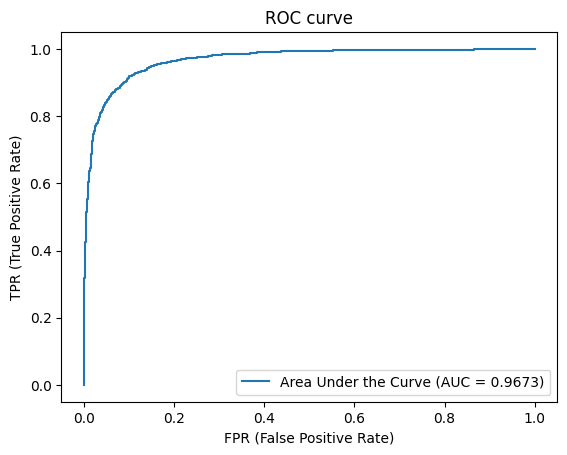

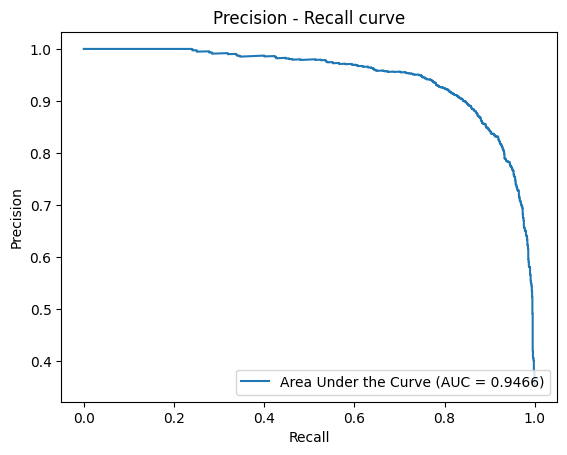

In [22]:
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
#plt.savefig(path_experiment+"ROC.png")
plt.savefig('Promoter-dataset-1-one-hot-code-ROC.png')
#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
#plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
#print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
#print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
#print ("Precision: " +str(precision))

#Jaccard similarity index
#jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
#print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

mcc= matthews_corrcoef(y_true, y_pred)
print ('MCC:', mcc)


In [23]:
model.load_weights(best_weights)

In [24]:
enh_ind_pos = []
for seq_record in SeqIO.parse('datasets/Full-transcript-mode-test-Pos.txt', "fasta"):
    enh_ind_pos.append(str(seq_record.seq))
enh_ind_neg = []
for seq_record in SeqIO.parse('datasets/Full-transcript-mode-test-Neg.txt', "fasta"):
    enh_ind_neg.append(str(seq_record.seq))

In [25]:
enh_ind_comb = enh_ind_pos+enh_ind_neg

In [26]:
enh_ind_features = onehot(enh_ind_comb)
enh_ind_features=np.asarray(enh_ind_features,dtype=np.float)
enh_ind_features.shape


1231 41 4


(1231, 41, 4)

In [27]:
enh_kmer_ind=get_feature(enh_ind_comb,patterns)


In [29]:
lbs = list(np.ones(len(enh_ind_pos))) + list(np.zeros(len(enh_ind_neg)))


In [30]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder() 
lbs = np.array(lbs).reshape(-1, 1)
Input_labels = one_hot_encoder.fit_transform(lbs).toarray()
Input_labels = np.array(lbs)
Input_labels.shape

(1231, 1)

In [31]:
np.save('m5U/enh_folds/enh_ind_test',enh_ind_features)
np.save('m5U/enh_folds/enh_ind_kmer',enh_kmer_ind)
np.save('m5U/enh_folds/ind_y_test',Input_labels)


In [32]:
enh_ind_test,test_labels=np.load('m5U/enh_folds/enh_ind_test.npy'), np.load('m5U/enh_folds/ind_y_test.npy')
enh_kmer_ind = np.load('m5U/enh_folds/enh_ind_kmer.npy')
y_scores= model.predict([enh_ind_test,enh_kmer_ind])
y_true=test_labels



Area under the ROC curve: 0.9536497948016416

Area under Precision-Recall curve: 0.9438530876776774
Global Accuracy: 0.8943948009748173
Specificity: 0.9110807113543091
Sensitivity: 0.87

F1 score (F-measure): 0.87
MCC: 0.7810807113543091


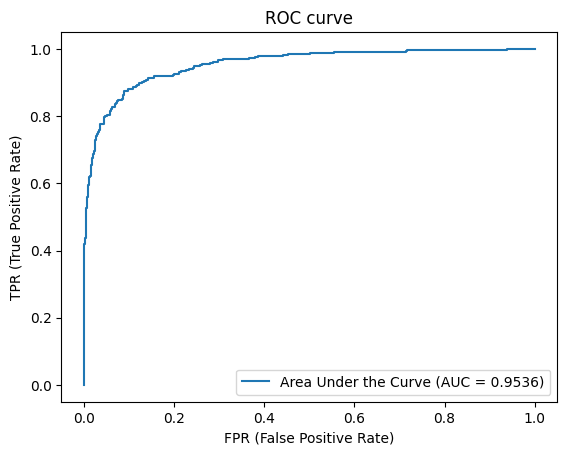

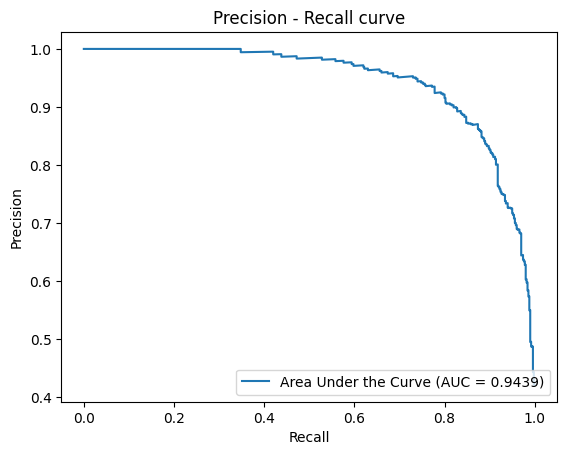

In [33]:
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
#plt.savefig(path_experiment+"ROC.png")
plt.savefig('Promoter-dataset-1-one-hot-code-ROC.png')
#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
#plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
#print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
#print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
#print ("Precision: " +str(precision))

#Jaccard similarity index
#jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
#print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

mcc= matthews_corrcoef(y_true, y_pred)
print ('MCC:', mcc)
